In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("../Data/Housing.csv")
print(df.head())
print("\nDataset shape:", df.shape)

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset shape: (545, 13)


In [64]:
# Data preprocessing
# Convert categorical variables to numerical
label_encoders = {}
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select features and target
feature_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 
                'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
target_col = 'price'

X = df[feature_cols].values
y = df[target_col].values

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (545, 12)
Target vector shape: (545,)


In [65]:
# Check for missing or infinite values
print("\nChecking for issues in the data:")
print("Missing values:", np.any(np.isnan(X)))
print("Infinite values:", np.any(np.isinf(X)))

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Clip extreme values before scaling (beyond 3 standard deviations)
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_clipped = np.clip(X, X_mean - 3 * X_std, X_mean + 3 * X_std)

X_scaled = scaler_X.fit_transform(X_clipped)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Add bias term
n_samples, n_features = X_scaled.shape
X_bias = np.c_[np.ones((n_samples, 1)), X_scaled]

# Verify scaled data
print("\nVerifying scaled data:")
print("X_scaled mean:", np.mean(X_scaled, axis=0))
print("X_scaled std:", np.std(X_scaled, axis=0))
print("y_scaled mean:", np.mean(y_scaled))
print("y_scaled std:", np.std(y_scaled))

print("\nScaled feature matrix shape:", X_scaled.shape)
print("Scaled target vector shape:", y_scaled.shape)

# Check for any remaining issues
print("\nFinal data check:")
print("NaN in X_scaled:", np.any(np.isnan(X_scaled)))
print("NaN in y_scaled:", np.any(np.isnan(y_scaled)))
print("Inf in X_scaled:", np.any(np.isinf(X_scaled)))
print("Inf in y_scaled:", np.any(np.isinf(y_scaled)))


Checking for issues in the data:
Missing values: False
Infinite values: False

Verifying scaled data:
X_scaled mean: [ 5.21499256e-17 -2.60749628e-16  2.60749628e-17 -1.30374814e-16
 -1.82524739e-16  5.21499256e-17 -7.82248883e-17  4.88905552e-17
 -5.21499256e-17  0.00000000e+00  0.00000000e+00  1.82524739e-16]
X_scaled std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
y_scaled mean: 2.0859970224149731e-16
y_scaled std: 0.9999999999999998

Scaled feature matrix shape: (545, 12)
Scaled target vector shape: (545,)

Final data check:
NaN in X_scaled: False
NaN in y_scaled: False
Inf in X_scaled: False
Inf in y_scaled: False


In [66]:
# Set hyperparameters
epochs = 100
learning_rates = [0.001, 0.01, 0.1]

# Dictionary to store results for each learning rate
batch_results = {}
sgd_results = {}
mini_batch_results = {}

# Dictionary to store final weights for each learning rate
final_weights = {
    'batch': {},
    'sgd': {},
    'mini_batch': {}
}

# Gradient Descent Training Configuration

We will compare three gradient descent variants with different learning rates:
- Batch Gradient Descent: Uses entire dataset for each update
- Stochastic Gradient Descent: Uses one sample at a time
- Mini-Batch Gradient Descent: Uses small batches of data (32 samples)

Learning rates to test: 0.001, 0.01, 0.1
Number of epochs: 100

## Batch Gradient Descent

In [67]:
def batch_gradient_descent_with_history(x, y, lr, epochs):
    weights = np.zeros(x.shape[1])
    history = []
    
    # Compute scaling factor for gradient clipping
    max_norm = np.sqrt(x.shape[1])
    
    for epoch in range(epochs):
        # Forward pass with numerical stability check
        predictions = x @ weights
        error = predictions - y
        
        # Compute gradient with numerical stability
        gradient = (2 / len(y)) * x.T @ error
        
        # Gradient clipping to prevent exploding gradients
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > max_norm:
            gradient = gradient * (max_norm / gradient_norm)
        
        # Update weights
        weights -= lr * gradient
        
        # Compute MSE with numerical stability
        mse = np.mean(np.clip(error ** 2, -1e10, 1e10))
        history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[Batch] LR={lr:.3f}, Epoch {epoch+1}: MSE = {mse:.4f}")
    
    return weights, history

## Stochastic Gradient Descent

In [68]:
def stochastic_gradient_descent_with_history(x, y, lr, epochs):
    weights = np.zeros(x.shape[1])
    history = []
    
    # Compute scaling factor for gradient clipping
    max_norm = np.sqrt(x.shape[1])
    
    for epoch in range(epochs):
        epoch_losses = []
        indices = np.random.permutation(len(y))  # Shuffle data each epoch
        
        for i in indices:
            xi = x[i]
            yi = y[i]
            
            # Forward pass with numerical stability
            prediction = np.dot(xi, weights)
            error = prediction - yi
            
            # Compute gradient
            gradient = 2 * error * xi
            
            # Gradient clipping
            gradient_norm = np.linalg.norm(gradient)
            if gradient_norm > max_norm:
                gradient = gradient * (max_norm / gradient_norm)
            
            # Update weights
            weights -= lr * gradient
            
            # Store loss with numerical stability
            loss = np.clip(error**2, -1e10, 1e10)
            epoch_losses.append(loss)
            
        mse = np.mean(epoch_losses)
        history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[SGD] LR={lr:.3f}, Epoch {epoch+1}: MSE = {mse:.4f}")
    
    return weights, history

## Mini-Batch Gradient Descent

In [69]:
def mini_batch_gradient_descent_with_history(x, y, lr, epochs, batch_size=32):
    weights = np.zeros(x.shape[1])
    history = []
    n = len(y)
    
    # Compute scaling factor for gradient clipping
    max_norm = np.sqrt(x.shape[1])
    
    for epoch in range(epochs):
        epoch_losses = []
        indices = np.arange(n)
        np.random.shuffle(indices)
        x_shuffled = x[indices]
        y_shuffled = y[indices]
        
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)  # Ensure we don't go past array bounds
            xb = x_shuffled[start:end]
            yb = y_shuffled[start:end]
            
            # Forward pass with numerical stability
            predictions = xb @ weights
            error = predictions - yb
            
            # Compute gradient with numerical stability
            gradient = (2 / len(yb)) * xb.T @ error
            
            # Gradient clipping
            gradient_norm = np.linalg.norm(gradient)
            if gradient_norm > max_norm:
                gradient = gradient * (max_norm / gradient_norm)
            
            # Update weights
            weights -= lr * gradient
            
            # Store loss with numerical stability
            batch_loss = np.mean(np.clip(error**2, -1e10, 1e10))
            epoch_losses.append(batch_loss)
        
        mse = np.mean(epoch_losses)
        history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"[Mini-Batch] LR={lr:.3f}, Epoch {epoch+1}: MSE = {mse:.4f}")
    
    return weights, history

In [70]:
# Train models with different learning rates
for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")
    
    # Batch Gradient Descent
    print("\n--- Running Batch Gradient Descent ---")
    w_batch, history_batch = batch_gradient_descent_with_history(X_bias, y_scaled, lr, epochs)
    batch_results[lr] = history_batch
    final_weights['batch'][lr] = w_batch
    
    # Stochastic Gradient Descent
    print("\n--- Running Stochastic Gradient Descent ---")
    w_sgd, history_sgd = stochastic_gradient_descent_with_history(X_bias, y_scaled, lr, epochs)
    sgd_results[lr] = history_sgd
    final_weights['sgd'][lr] = w_sgd
    
    # Mini-Batch Gradient Descent
    print("\n--- Running Mini-Batch Gradient Descent ---")
    w_mini, history_mini = mini_batch_gradient_descent_with_history(X_bias, y_scaled, lr, epochs, batch_size=32)
    mini_batch_results[lr] = history_mini
    final_weights['mini_batch'][lr] = w_mini

# Select the best weights (using learning rate 0.01)
w_batch = final_weights['batch'][0.01]
w_sgd = final_weights['sgd'][0.01]
w_minibatch = final_weights['mini_batch'][0.01]

print("\nFinal weights shapes:")
print(f"Batch GD: {w_batch.shape}")
print(f"SGD: {w_sgd.shape}")
print(f"Mini-batch GD: {w_minibatch.shape}")


=== Training with Learning Rate: 0.001 ===

--- Running Batch Gradient Descent ---
[Batch] LR=0.001, Epoch 1: MSE = 1.0000
[Batch] LR=0.001, Epoch 10: MSE = 0.9439
[Batch] LR=0.001, Epoch 20: MSE = 0.8872
[Batch] LR=0.001, Epoch 30: MSE = 0.8358
[Batch] LR=0.001, Epoch 40: MSE = 0.7892
[Batch] LR=0.001, Epoch 50: MSE = 0.7471
[Batch] LR=0.001, Epoch 60: MSE = 0.7089
[Batch] LR=0.001, Epoch 70: MSE = 0.6742
[Batch] LR=0.001, Epoch 80: MSE = 0.6429
[Batch] LR=0.001, Epoch 90: MSE = 0.6144
[Batch] LR=0.001, Epoch 100: MSE = 0.5887

--- Running Stochastic Gradient Descent ---
[SGD] LR=0.001, Epoch 1: MSE = 0.6120


[SGD] LR=0.001, Epoch 10: MSE = 0.3402
[SGD] LR=0.001, Epoch 20: MSE = 0.3361
[SGD] LR=0.001, Epoch 30: MSE = 0.3387
[SGD] LR=0.001, Epoch 40: MSE = 0.3393
[SGD] LR=0.001, Epoch 50: MSE = 0.3379
[SGD] LR=0.001, Epoch 60: MSE = 0.3398
[SGD] LR=0.001, Epoch 70: MSE = 0.3388
[SGD] LR=0.001, Epoch 80: MSE = 0.3383
[SGD] LR=0.001, Epoch 90: MSE = 0.3390
[SGD] LR=0.001, Epoch 100: MSE = 0.3394

--- Running Mini-Batch Gradient Descent ---
[Mini-Batch] LR=0.001, Epoch 1: MSE = 0.9210
[Mini-Batch] LR=0.001, Epoch 10: MSE = 0.4758
[Mini-Batch] LR=0.001, Epoch 20: MSE = 0.3419
[Mini-Batch] LR=0.001, Epoch 30: MSE = 0.3192
[Mini-Batch] LR=0.001, Epoch 40: MSE = 0.3152
[Mini-Batch] LR=0.001, Epoch 50: MSE = 0.3323
[Mini-Batch] LR=0.001, Epoch 60: MSE = 0.3147
[Mini-Batch] LR=0.001, Epoch 70: MSE = 0.3093
[Mini-Batch] LR=0.001, Epoch 80: MSE = 0.3175
[Mini-Batch] LR=0.001, Epoch 90: MSE = 0.3239
[Mini-Batch] LR=0.001, Epoch 100: MSE = 0.3239

=== Training with Learning Rate: 0.01 ===

--- Running Ba

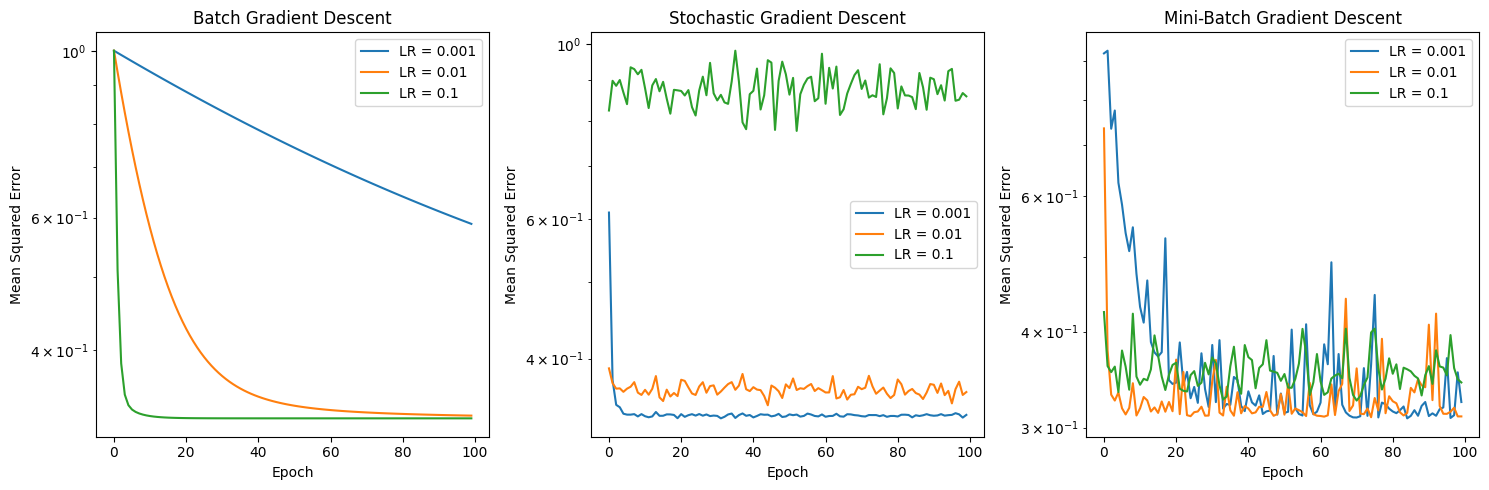


Final Mean Squared Error:

Learning Rate: 0.001
Batch GD: 0.588656
SGD: 0.339387
Mini-Batch GD: 0.323884

Learning Rate: 0.01
Batch GD: 0.327331
SGD: 0.362772
Mini-Batch GD: 0.310226

Learning Rate: 0.1
Batch GD: 0.324622
SGD: 0.858743
Mini-Batch GD: 0.343485


In [71]:
# Plot learning curves for different learning rates
plt.figure(figsize=(15, 5))

# Plot Batch Gradient Descent results
plt.subplot(131)
for lr in learning_rates:
    plt.plot(batch_results[lr], label=f'LR = {lr}')
plt.title('Batch Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

# Plot Stochastic Gradient Descent results
plt.subplot(132)
for lr in learning_rates:
    plt.plot(sgd_results[lr], label=f'LR = {lr}')
plt.title('Stochastic Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

# Plot Mini-Batch Gradient Descent results
plt.subplot(133)
for lr in learning_rates:
    plt.plot(mini_batch_results[lr], label=f'LR = {lr}')
plt.title('Mini-Batch Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print final MSE for each method and learning rate
print("\nFinal Mean Squared Error:")
print("=" * 50)
for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    print(f"Batch GD: {batch_results[lr][-1]:.6f}")
    print(f"SGD: {sgd_results[lr][-1]:.6f}")
    print(f"Mini-Batch GD: {mini_batch_results[lr][-1]:.6f}")

# Learning Curves Analysis

Comparing learning curves across different learning rates and methods:
- Left plot: Batch Gradient Descent learning curves
- Middle plot: Stochastic Gradient Descent learning curves
- Right plot: Mini-Batch Gradient Descent learning curves

Using logarithmic scale to better visualize the error reduction.

In [72]:
# Compare results and make predictions
print("\n=== Model Comparison ===")
print(f"Feature names: {['bias'] + feature_cols}")

print("\nBatch GD weights:")
for i, (name, weight) in enumerate(zip(['bias'] + feature_cols, w_batch)):
    print(f"  {name}: {weight:.4f}")

print("\nSGD weights:")
for i, (name, weight) in enumerate(zip(['bias'] + feature_cols, w_sgd)):
    print(f"  {name}: {weight:.4f}")

print("\nMini-Batch GD weights:")
for i, (name, weight) in enumerate(zip(['bias'] + feature_cols, w_minibatch)):
    print(f"  {name}: {weight:.4f}")


=== Model Comparison ===
Feature names: ['bias', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Batch GD weights:
  bias: 0.0000
  area: 0.2565
  bedrooms: 0.0922
  bathrooms: 0.2391
  stories: 0.1850
  mainroad: 0.0947
  guestroom: 0.0744
  basement: 0.0739
  hotwaterheating: 0.0818
  airconditioning: 0.2025
  parking: 0.1396
  prefarea: 0.1388
  furnishingstatus: -0.0945

SGD weights:
  bias: -0.0339
  area: 0.2040
  bedrooms: 0.0724
  bathrooms: 0.2737
  stories: 0.1948
  mainroad: 0.0535
  guestroom: 0.0752
  basement: 0.1401
  hotwaterheating: 0.1124
  airconditioning: 0.1645
  parking: 0.1120
  prefarea: 0.1983
  furnishingstatus: -0.0661

Mini-Batch GD weights:
  bias: 0.0018
  area: 0.2835
  bedrooms: 0.0430
  bathrooms: 0.2636
  stories: 0.2040
  mainroad: 0.0729
  guestroom: 0.0586
  basement: 0.0926
  hotwaterheating: 0.0972
  airconditioning: 0.2180
  parking

In [73]:
def evaluate_model(x, y, weights, model_name):
    # Make predictions with numerical stability
    predictions = x @ weights
    predictions = np.clip(predictions, -1e10, 1e10)
    
    # Calculate MSE with numerical stability
    errors = y - predictions
    squared_errors = np.clip(errors ** 2, -1e10, 1e10)
    mse = np.mean(squared_errors)
    
    # Calculate R-squared with numerical stability
    y_mean = np.mean(y)
    ss_total = np.sum(np.clip((y - y_mean) ** 2, -1e10, 1e10))
    ss_residual = np.sum(squared_errors)
    
    # Handle potential numerical issues
    if ss_total == 0 or np.isnan(ss_total) or np.isinf(ss_total):
        r_squared = 0
    else:
        r_squared = 1 - (ss_residual / ss_total)
        # Clip R-squared to valid range [0, 1]
        r_squared = np.clip(r_squared, 0, 1)
    
    print(f"\n{model_name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared Score: {r_squared:.4f}")
    
    # Additional diagnostic information
    print(f"Max absolute prediction: {np.max(np.abs(predictions)):.4f}")
    print(f"Max absolute error: {np.max(np.abs(errors)):.4f}")
    print(f"Number of NaN predictions: {np.sum(np.isnan(predictions))}")
    print(f"Number of Inf predictions: {np.sum(np.isinf(predictions))}")
    
    return mse, r_squared

# Evaluate all three models using the weights from learning rate 0.01
print("=== Model Evaluation ===")
mse_batch, r2_batch = evaluate_model(X_bias, y_scaled, w_batch, "Batch Gradient Descent")
mse_sgd, r2_sgd = evaluate_model(X_bias, y_scaled, w_sgd, "Stochastic Gradient Descent")
mse_mini, r2_mini = evaluate_model(X_bias, y_scaled, w_minibatch, "Mini-Batch Gradient Descent")

# Create a comparison table
results = pd.DataFrame({
    'Method': ['Batch GD', 'SGD', 'Mini-Batch GD'],
    'MSE': [mse_batch, mse_sgd, mse_mini],
    'R-squared': [r2_batch, r2_sgd, r2_mini]
})

print("\nComparison Table:")
print(results.to_string(index=False))

=== Model Evaluation ===

Batch Gradient Descent Results:
Mean Squared Error: 0.3273
R-squared Score: 0.6727
Max absolute prediction: 2.4898
Max absolute error: 2.7107
Number of NaN predictions: 0
Number of Inf predictions: 0

Stochastic Gradient Descent Results:
Mean Squared Error: 0.3445
R-squared Score: 0.6555
Max absolute prediction: 2.4017
Max absolute error: 2.8689
Number of NaN predictions: 0
Number of Inf predictions: 0

Mini-Batch Gradient Descent Results:
Mean Squared Error: 0.3248
R-squared Score: 0.6752
Max absolute prediction: 2.5782
Max absolute error: 2.7076
Number of NaN predictions: 0
Number of Inf predictions: 0

Comparison Table:
       Method      MSE  R-squared
     Batch GD 0.327266   0.672734
          SGD 0.344505   0.655495
Mini-Batch GD 0.324776   0.675224


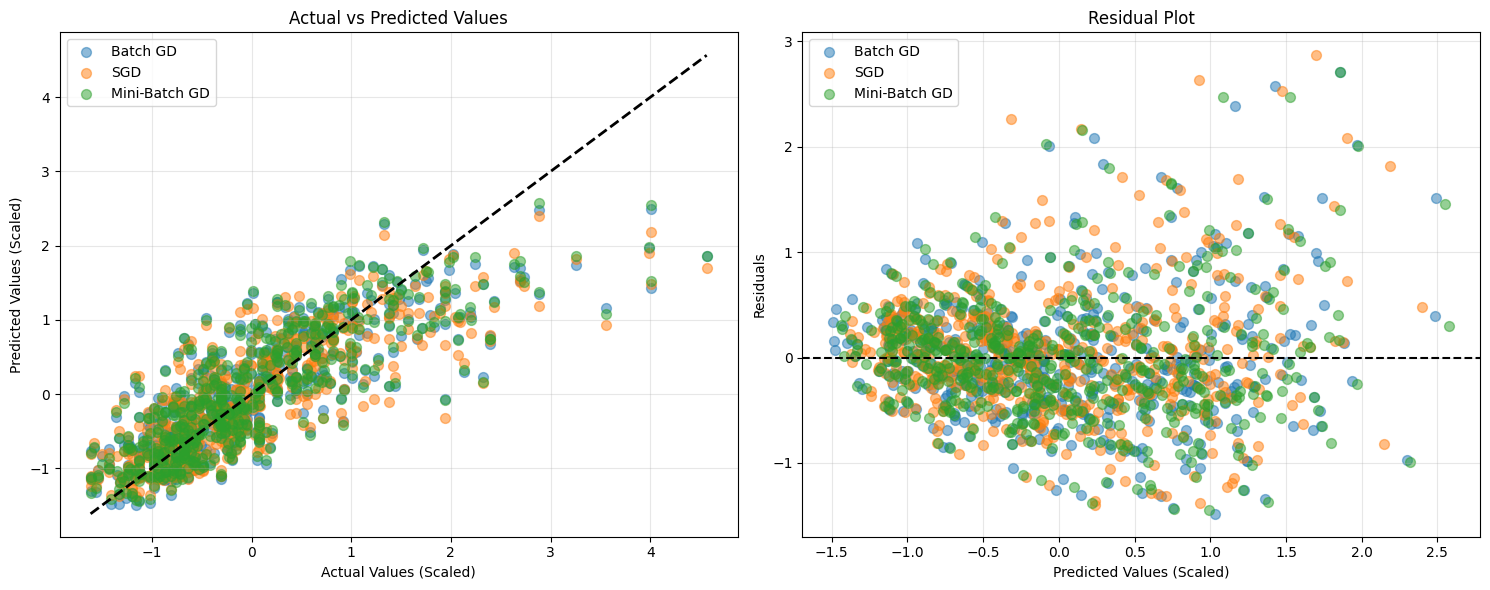

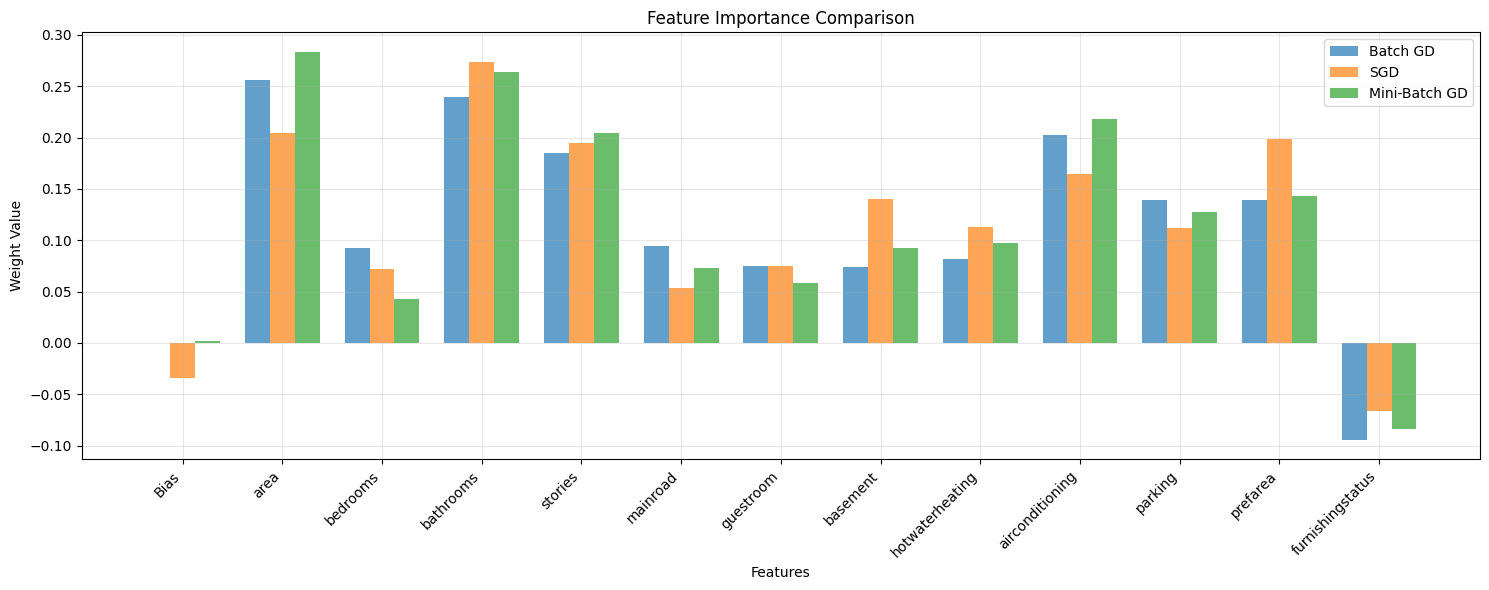

In [74]:
# Calculate predictions for each model
predictions_batch = X_bias @ w_batch
predictions_sgd = X_bias @ w_sgd
predictions_mini = X_bias @ w_minibatch

# Create scatter plots
plt.figure(figsize=(15, 6))

# Actual vs Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_scaled, predictions_batch, alpha=0.5, label='Batch GD', s=50)
plt.scatter(y_scaled, predictions_sgd, alpha=0.5, label='SGD', s=50)
plt.scatter(y_scaled, predictions_mini, alpha=0.5, label='Mini-Batch GD', s=50)
plt.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=2)
plt.xlabel('Actual Values (Scaled)')
plt.ylabel('Predicted Values (Scaled)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plots
plt.subplot(1, 2, 2)
plt.scatter(predictions_batch, y_scaled - predictions_batch, alpha=0.5, label='Batch GD', s=50)
plt.scatter(predictions_sgd, y_scaled - predictions_sgd, alpha=0.5, label='SGD', s=50)
plt.scatter(predictions_mini, y_scaled - predictions_mini, alpha=0.5, label='Mini-Batch GD', s=50)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Values (Scaled)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a plot to show feature importance
plt.figure(figsize=(15, 6))
feature_names = ['Bias'] + feature_cols
x_pos = np.arange(len(feature_names))
width = 0.25

plt.bar(x_pos - width, w_batch, width, label='Batch GD', alpha=0.7)
plt.bar(x_pos, w_sgd, width, label='SGD', alpha=0.7)
plt.bar(x_pos + width, w_minibatch, width, label='Mini-Batch GD', alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Weight Value')
plt.title('Feature Importance Comparison')
plt.xticks(x_pos, feature_names, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Model Performance Visualization

1. **Actual vs Predicted Values**: Shows how well each model's predictions align with actual values
   - Points closer to the diagonal line indicate better predictions
   - More spread indicates higher prediction error

2. **Residual Plot**: Shows the distribution of errors
   - Points should be randomly scattered around zero
   - No clear patterns indicate good model fit

3. **Feature Importance**: Compares the learned weights across models
   - Larger absolute weights indicate more influential features
   - Comparing weights across methods shows consistency in feature importance